In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


warnings.filterwarnings("ignore")

## Dataset

Beijing, China

In [53]:
df = pd.read_csv("beijing_pollution_dataset.csv")

## EDA

In [54]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [55]:
df.tail()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43799,2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [57]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


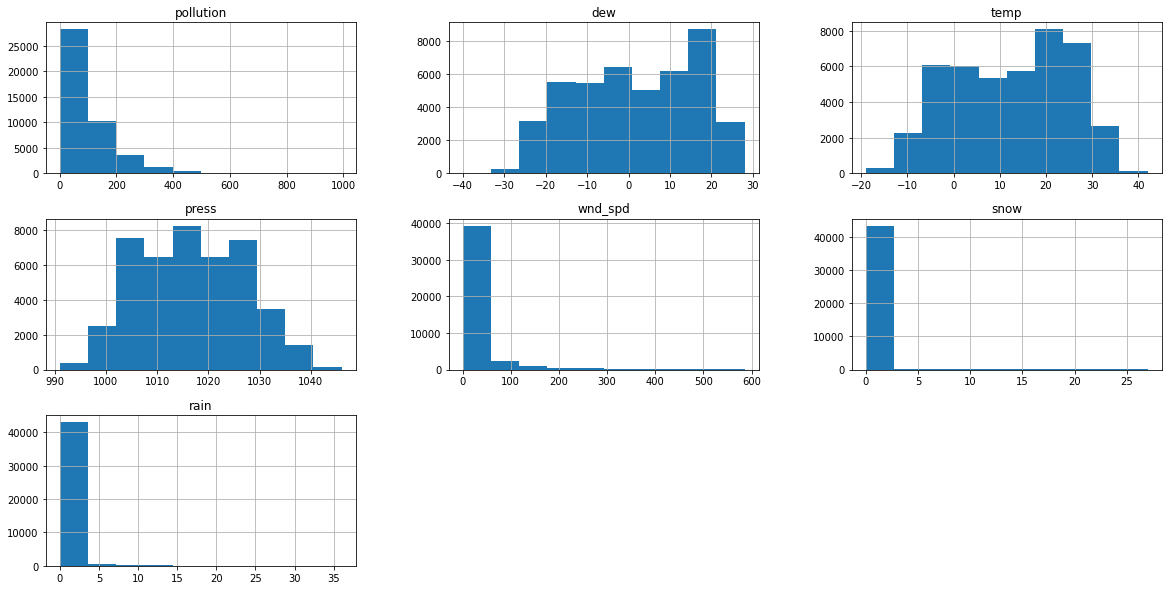

In [58]:
df.hist(figsize = (20,10))
plt.show()

## Cleaning

### Handle Wind Direction

SE -> South East

cv -> Calm & Vary

NW -> North West

NE -> North East

In [59]:
df.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

Categorical To Boolean

In [60]:
df = pd.get_dummies(df, columns = ["wnd_dir"],drop_first = True)

In [61]:
df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,1,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,1,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,1,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,1,0


### Handle Date Index

In [62]:
df.set_index(["date"], inplace = True)

In [63]:
df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,1,0


## Time series Part

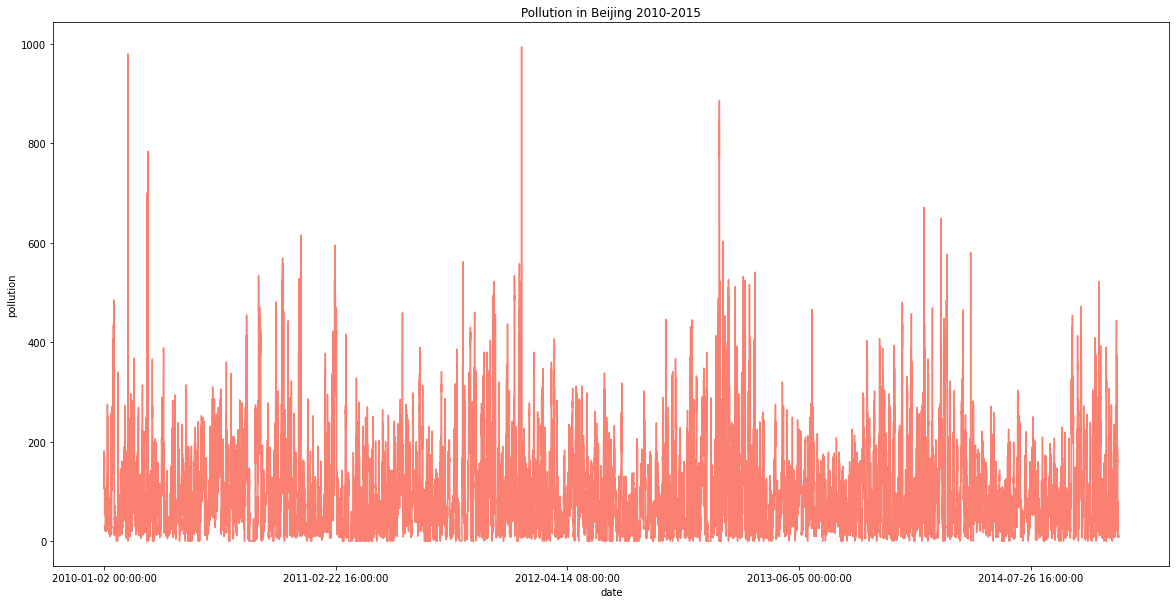

In [64]:
df.pollution.plot(figsize = (20,10), title = "Pollution in Beijing 2010-2015", ylabel = 'pollution', c = 'salmon')
plt.show()

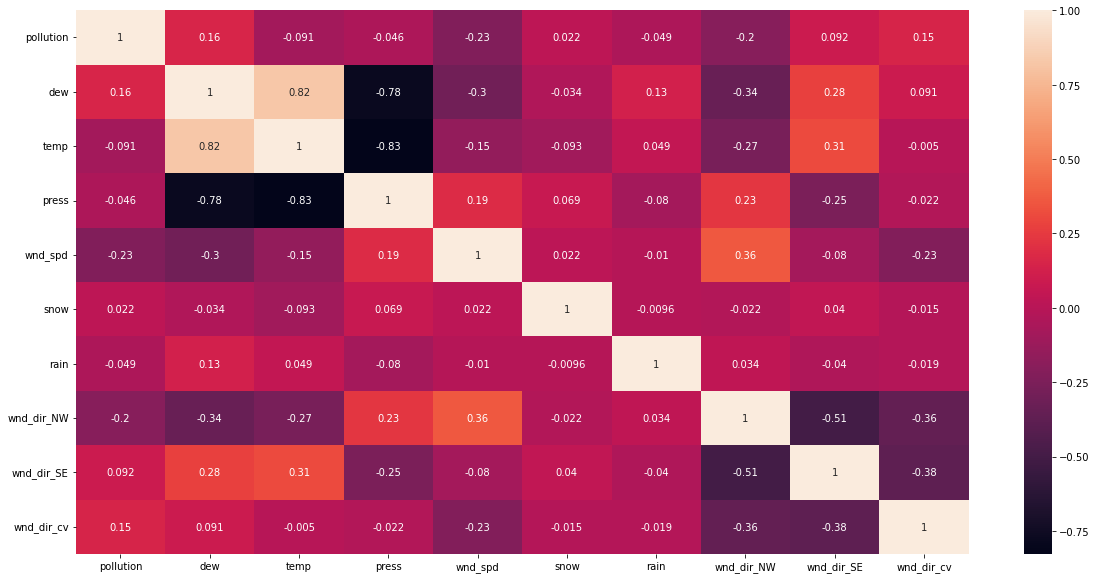

In [65]:
fig, ax1 = plt.subplots(figsize = (20,10))
sns.heatmap(df.corr(), ax = ax1, annot = True, cmap = 'rocket')
plt.show()

## Stationary

In [66]:
pollution = df.pollution

In [67]:
adfuller_result = adfuller(pollution)
pvalue = adfuller_result[1]
if pvalue < 0.05:
    print("stationary")
else:
    print("non-stationary")
print(adfuller_result)

stationary
(-21.00410852840915, 0.0, 55, 43744, {'1%': -3.430499498988984, '5%': -2.8616060752745827, '10%': -2.5668051697196077}, 413105.86371572455)


## ACF & PACF

In [68]:
# fig, (ax2, ax3) = plt.subplots(figsize = (20,10), ncols = 2)
# plot_acf(pollution, lags = 20000, ax = ax2)
# plot_pacf(pollution, lags = 20000, ax = ax3)
# plt.show()

## Classic

### ARIMA

In [78]:
slice_p = pollution.iloc[:100]

In [84]:
train, test = train_test_split(slice_p, test_size = 0.2 , shuffle = False)
fcst = []
for i in range(test.shape[0]):
    sarimax = SARIMAX(train, order = (4,0,0))
    res = sarimax.fit(disp = False)
    fcst.append(res.forecast(steps = 1))
    train = train.append(pd.Series(test.iloc[i]))
score = r2_score(fcst, test)
score

0.506627781783282

In [ ]:
# Author : amyrmahdy
# Date : 12 Jan 2023